---
title: Static Analytical CTF Plots  
authors: [Julie Marie Bekkevold, Georgios Varnavides]  
date: 2025-04-22  
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import ctf # import custom plotting / utils
import cmasher as cmr 
import tqdm

In [2]:
# parameters
n = 96
q_max = 2 # inverse Angstroms
q_probe = 1 # inverse Angstroms
wavelength = 0.019687 # 300kV
sampling = 1 / q_max / 2 # Angstroms
reciprocal_sampling = 2 * q_max / n # inverse Angstroms

scan_step_size = 1 # pixels
sx = sy = n//scan_step_size
C10 = 0

cmap = cmr.viola

In [5]:
# we build probe in Fourier space, using a soft aperture

qx = qy = np.fft.fftfreq(n,sampling)
q2 = qx[:,None]**2 + qy[None,:]**2
q  = np.sqrt(q2)
theta = np.arctan2(qy[None,:],qx[:,None])

probe_array_fourier_0 = np.sqrt(
    np.clip(
        (q_probe - q)/reciprocal_sampling + 0.5,
        0,
        1,
    ),
)

def return_chi(
    q,
    theta,
    wavelength,
    C10,
    C12,
    phi12,
    C21,
    phi21,
    C30,
):
    """ """
    prefactor = 2*np.pi / wavelength
    alpha = q*wavelength
    order_2 = alpha**2 / 2 * (C10 + C12*np.cos(2*(theta-phi12)))
    order_3 = alpha**3 / 3 * C21*np.cos(theta-phi21)
    order_4 = alpha**4 / 4 * C30
    
    return (order_2+order_3+order_4) * prefactor

unrolled_chi = return_chi(
    q,
    theta,
    wavelength,
    C10=C10,
    C12=0,
    phi12=np.deg2rad(0),
    C21=0,
    phi21=np.deg2rad(0),
    C30=0
)
# unrolled_chi = return_chi(
#     q,
#     theta,
#     wavelength,
#     C10=100,
#     C12=0,
#     phi12=np.deg2rad(20),
#     C21=1000,
#     phi21=np.deg2rad(840),
#     C30=0
# )
probe_array_fourier = probe_array_fourier_0 * np.exp(-1j * unrolled_chi)
probe_array_fourier /= np.sqrt(np.sum(np.abs(probe_array_fourier)**2))

## iCOM

In [7]:
def array_correlation(array1,array2):
    """ """
    return np.real(
        np.fft.ifft2(
            np.fft.fft2(array1).conj() * np.fft.fft2(array2)
        )
    )

def asymmetric_array_correlation(array1,array2):
    """ """
    return array_correlation(array1,array2) - array_correlation(array2,array1)


In [8]:
ctf_x = asymmetric_array_correlation(
    probe_array_fourier * qx[:,None],
    probe_array_fourier
)

ctf_y = asymmetric_array_correlation(
    probe_array_fourier * qy[None,:],
    probe_array_fourier
)

with np.errstate(invalid="ignore"):
    scalar_ctf = np.imag((qx[:,None] * ctf_x + qy[None,:] * ctf_y) / (1j*q2))
    scalar_ctf[0,0] = 1.0

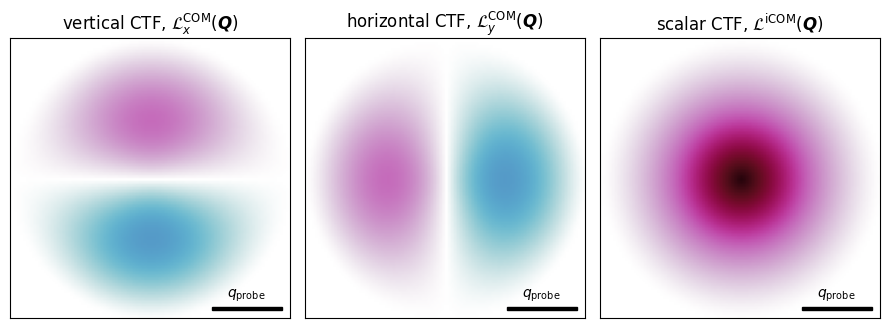

In [9]:
#| label: app:pixelated_icom_static

# dpi=72
# fig, axs = plt.subplots(1,3,figsize=(640/dpi,270/dpi),dpi=dpi)

fig, axs = plt.subplots(1,3,figsize=(9,3.5))

kwargs = {"cmap":cmap,"vmin":-1,"vmax":1}
for ax, arr, title in zip(
    axs,
    [ctf_x,ctf_y,scalar_ctf],
    [
        r"vertical CTF, $\mathcal{L}_x^{\mathrm{COM}}(\boldsymbol{Q})$",
        r"horizontal CTF, $\mathcal{L}_y^{\mathrm{COM}}(\boldsymbol{Q})$",
        r"scalar CTF, $\mathcal{L}^{\mathrm{iCOM}}(\boldsymbol{Q})$",
    ]
):
    ax.imshow(
        np.fft.fftshift(
            arr
        ),
        **kwargs
    )
    ctf.add_scalebar(
        ax,
        length=n//4,
        sampling=reciprocal_sampling,
        units=r'$q_{\mathrm{probe}}$',
        color="black"
    )
    ax.set(xticks=[],yticks=[],title=title)

fig.tight_layout()

## SSB

In [10]:
# def return_aperture_overlap(
#     complex_probe,
#     ind_x,
#     ind_y,
# ):
#     """ """

#     shifted_probe_plus = np.roll(complex_probe,(-ind_x,-ind_y),axis=(0,1))
#     shifted_probe_minus = np.roll(complex_probe,(ind_x,ind_y),axis=(0,1))

#     gamma = complex_probe.conj() * shifted_probe_minus - complex_probe * shifted_probe_plus.conj()
    
#     return gamma

# def return_ssb_ctf(
#     complex_probe,
#     progress_bar = False
# ):
#     """ """
#     gamma_array = np.zeros((n,n))
    
#     for ind_x in range(n):
#         for ind_y in range(n):
#             omega = q[ind_x,ind_y]
#             if omega < 2*q_probe:
#                 gamma_array[ind_x,ind_y] = np.abs(
#                     return_aperture_overlap(
#                         complex_probe,
#                         ind_x,
#                         ind_y
#                     )
#                 ).sum() / 2
                
#     return gamma_array   

In [11]:
# def return_aperture_overlap_2(
#     normalized_aperture,
#     unrolled_chi,
#     ind_x,
#     ind_y,
# ):
#     """ """
    
#     return (
#         np.exp(-1j*unrolled_chi) * np.roll(normalized_aperture,(ind_x,ind_y),(0,1))
#         - np.exp(1j*unrolled_chi) * np.roll(normalized_aperture,(-ind_x,-ind_y),(0,1))
#     )

In [12]:
# large_gamma_array_2 = np.zeros((n,n,n,n),dtype=np.complex128)
# for ind_x in range(n):
#     for ind_y in range(n):
#         omega = q[ind_x,ind_y]
#         if omega < 2*q_probe:
            
#             large_gamma_array_2[...,ind_x,ind_y] = return_aperture_overlap_2(
#                 np.abs(probe_array_fourier),
#                 unrolled_chi,
#                 ind_x,
#                 ind_y
#             )
            
# large_gamma_array_2 *= np.abs(probe_array_fourier) 
# large_gamma_array_3 = large_gamma_array_2 * shift_op.conj()

In [13]:
# large_gamma_array = np.zeros((n,n,n,n),dtype=np.complex128)
# for ind_x in range(n):
#     for ind_y in range(n):
#         omega = q[ind_x,ind_y]
#         if omega < 2*q_probe:
#             large_gamma_array[ind_x,ind_y] = return_aperture_overlap(
#                 probe_array_fourier,
#                 ind_x,
#                 ind_y
#             )

In [14]:
# fig, axs = plt.subplots(1,3,figsize=(12,4))

# axs[0].imshow(
#     ctf.complex_to_rgb(
#         np.fft.fftshift(
#             large_gamma_array[...,22,0]
#         )
#     )
# )

# axs[1].imshow(
#     ctf.complex_to_rgb(
#         np.fft.fftshift(
#             large_gamma_array_2[...,22,0]
#         )
#     )
# )

# axs[2].imshow(
#     ctf.complex_to_rgb(
#         np.fft.fftshift(
#             large_gamma_array_3[...,22,0]
#         )
#     )
# )

# fig.tight_layout()

In [15]:
# plt.imshow(
#     np.fft.fftshift(
#         large_gamma_array_2.sum((-1,-2)).imag / 2
#     )
# )
# plt.colorbar()

In [16]:
# ssb_ctf = return_ssb_ctf(
#     probe_array_fourier
# )

In [17]:
# plt.imshow(
#     np.fft.fftshift(
#         ssb_ctf
#     )
# )

In [18]:
# def compute_weighted_ctf(
#     complex_probe,
#     corner_centered_masks,
#     progress_bar = False
# ):
#     """ """
#     ctf = np.zeros((n,n))
#     masks = np.array(corner_centered_masks)
#     asymmetric_masks = (masks - np.roll(masks[:,::-1,::-1],(1,1),(1,2)))/2
#     symmetric_masks = (masks + np.roll(masks[:,::-1,::-1],(1,1),(1,2)))/2

#     aperture = np.abs(complex_probe)
#     gamma = -np.angle(complex_probe)
#     for symm_mask,asymm_mask in tqdm.tqdm(zip(symmetric_masks,asymmetric_masks),total=symmetric_masks.shape[0], disable = not progress_bar):
#         for i in range(n):
#             for j in range(n):
#                 shifted_aperture = np.roll(aperture,(-i,-j),(0,1))
#                 shifted_gamma = np.roll(gamma,(-i,-j),(0,1))
#                 real_part = np.sum(aperture * shifted_aperture * symm_mask * np.sin(gamma-shifted_gamma))
#                 imag_part = np.sum(aperture * shifted_aperture * asymm_mask * np.cos(gamma-shifted_gamma))
#                 ctf[i,j] += np.abs(real_part + 1j*imag_part)
                
#     return ctf

In [19]:
# weighted_ctf = compute_weighted_ctf(
#     probe_array_fourier,
#     masks,
#     progress_bar=True
# )

In [20]:
# plt.imshow(
#     np.fft.fftshift(
#         weighted_ctf
#     )
# )
# plt.colorbar()